# <center>Variable-property and intrinsic compressibility corrections for turbulence models using near-wall scaling theories</center>

             Created on: July 8, 2024
           Developed by: Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Rene Pecnik (r.pecnik@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Oct 17, 2024 (Asif M. Hasan) 




In [1]:
import math as m
import numpy as np
import pandas as pd
import requests

from scipy.sparse import *
from scipy.linalg.lapack  import  dgtsv  as  lapack_dgtsv
from scipy.integrate import cumtrapz, trapz

import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d

# Grid with clustering at the wall

In [2]:

class Mesh:

    def __init__(self, 
                 n,       # Number of mesh points 
                 H,       # channel height
                 s,
                 tanhyp):      # factor to set mesh clustering at the wall;
                               # = 1 implies stretching on both sides (suitable for channels)
                               # =0.5 implies stretching only on one side (suitable for BLs) 
        self.n = n

        di = 1.0/(n-1)
        i = tanhyp*(np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = 1/tanhyp*H *(1.0 + np.tanh(s*i)/np.tanh(s/2))/2.0

        # cell faces
        self.yc = np.zeros(n-1)
        for ni in np.arange(0,n-1):
            self.yc[ni] = 0.5*( self.y[ni] + self.y[ni+1] ) 
        
        # ---------------------------------------------------------------------------------------------------
        #
        # First derivative: coefficient matrix for d()/dy
        #
        ddy                = np.zeros((n,n))
        ddy[0,0:2]     = [  -1/(self.y[1] - self.y[0]), 1/(self.y[1] - self.y[0])]
        ddy[n-1,n-2:n] = [  -1/(self.y[n-1] - self.y[n-2]), 1/(self.y[n-1] - self.y[n-2])]

        for i in range(1,n-1):
            ddy[i,i-1:i+2] = [  -1/(self.y[i+1] - self.y[i-1]), 0 , 1/(self.y[i+1] - self.y[i-1])  ]
        
        self.ddy = csr_matrix(ddy)
        
        # ---------------------------------------------------------------------------------------------------
        #
        # Second derivative: coefficient matrix for d2()/dy2 
        #
        d2dy2                = np.zeros((n,n))
        
        #Boundary cells
        a = 1/(self.y[1] - self.y[0])/(self.yc[1] - self.yc[0])
        c = 1/(self.y[2] - self.y[1])/(self.yc[1] - self.yc[0])
        b = -(a+c)
        d2dy2[0,  0:3  ] = [a,b,c]

        a = 1/(self.y[n-2] - self.y[n-3])/(self.yc[n-2] - self.yc[n-3])
        c = 1/(self.y[n-1] - self.y[n-2])/(self.yc[n-2] - self.yc[n-3])
        b = -(a+c)
        d2dy2[n-1,n-3:n]     = [a,b,c]
        
        # Non-boundary cells
        for i in range(1,n-1):
            a = 1/(self.y[i] - self.y[i-1])/(self.yc[i] - self.yc[i-1])
            c = 1/(self.y[i+1] - self.y[i])/(self.yc[i] - self.yc[i-1])
            b = -(a+c)
            d2dy2[i,i-1:i+2] = [ a ,b, c]                       # second order for all points within the domain 
        
        self.d2dy2 = csr_matrix(d2dy2)

    def solveEqn(self,x,A,b,omega):

        x_new = x.copy()

        b[0]  -= x[ 0]*A[1,0]    # boundary condition at y=0
        b[-1] -= x[-1]*A[-2,-1]  # boundary condition at the other end (eg: wall for channel)

        if (omega < 1.0):
            b[:] += (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
            A.setdiag(A.diagonal()/omega)
        
        x_new[1:-1] = lapack_dgtsv(A.diagonal(-1)[1:-1],
                                   A.diagonal( 0)[1:-1],
                                   A.diagonal( 1)[1:-1], b)[-2]

        return x_new, np.linalg.norm(x-x_new, ord=2)/len(x)  # also return L2 norm of delta x

## Menter's SST Model with the proposed corrections in Eq. (2.8), (2.10) and (3.3)

In [3]:
class SST:

    def __init__(self, underrelaxk = 0.8, underrelaxl = 0.8):
        self.underrelaxk = underrelaxk
        self.underrelaxl = underrelaxl

    def initTurbModel(self, mesh):
        self.k  = 0.01*np.ones_like(mesh.y)
        self.om = np.ones_like(mesh.y)
        
    def calcEddyVisc(self, mesh, u, r, mu, T, **params):

        n  = mesh.n
        k  = self.k
        om = self.om
    
        # model constants
        sigma_k1  = 0.85
        sigma_k2  = 1.0
        sigma_om1 = 0.5
        sigma_om2 = 0.856
        beta_1    = 0.075
        beta_2    = 0.0828
        betaStar  = 0.09
        a1        = 0.31
        alfa_1    = beta_1/betaStar - sigma_om1*0.41**2.0/betaStar**0.5
        alfa_2    = beta_2/betaStar - sigma_om2*0.41**2.0/betaStar**0.5    
            
        dudy  = mesh.ddy@u
        dkdy  = mesh.ddy@k     # grad k
        domdy = mesh.ddy@om    # grad omega
        
        wallDist = np.minimum(mesh.y, 2-mesh.y)
        wallDist = np.maximum(wallDist, 1.0e-16)

        # VortRate = StrainRate in fully developed channel
        strMag = np.absolute(dudy)
        
        # Blending functions 
        CDkom  = 2.0*sigma_om2*r/om*dkdy*domdy
        gamma1 = 500.0*mu/(r*om*wallDist*wallDist)
        gamma2 = 4.0*sigma_om2*r*k/(wallDist*wallDist*np.maximum(CDkom,1.0e-20))
        gamma3 = np.sqrt(k)/(betaStar*om*wallDist)
        gamma  = np.minimum(np.maximum(gamma1, gamma3), gamma2)
        bF1    = np.tanh(np.power(gamma, 4.0))
        gamma  = np.maximum(2.0*gamma3, gamma1)
        bF2    = np.tanh(np.power(gamma, 2.0))
    
        # model functions
        alfa     = alfa_1*bF1    + (1-bF1)*alfa_2
        beta     = beta_1*bF1    + (1-bF1)*beta_2
        sigma_k  = sigma_k1*bF1  + (1-bF1)*sigma_k2
        sigma_om = sigma_om1*bF1 + (1-bF1)*sigma_om2
        
        # Eddy viscosity
        zeta = np.minimum(1.0/np.maximum(om,1e-12), a1/np.maximum(strMag*bF2, 1e-12))
        ReTauSt = np.sqrt(r)/mu #mu already has ReTau
        yst     = wallDist*ReTauSt
        Rt      = np.maximum((r*k/(om*mu)),1e-12)
        Mt      = np.sqrt(2*r*k)*params['MaTau']
        Di      = (1 - np.exp(-Rt/(3.5)))**2
        Dc      = (1 - np.exp(-Rt/(3.5 + 0.39*(Mt)**0.77)))**2
        if (params['CompCorr'] == "VP+IC") :
            F       = Dc/Di
        else:
            F = np.ones_like(r)
        mut     = r*k*zeta*F
        mut     = np.minimum(np.maximum(mut,0.0),100.0)        
    
        # ---------------------------------------------------------------------
        #
        # om-equation
        #
        if params['CompCorr'] == "None":
    
            mueff = mu + sigma_om*mut
            fs    = np.ones(n)
            fd    = np.ones(n)
            S     = np.ones(n)
            source= np.zeros(n)
    
        elif params['CompCorr'] == "CA/OPDP":

            mueff = mu + sigma_om*mut
            fs    = np.ones(n)
            fd    = np.ones(n)
            S     = np.ones(n)
    
            mueff2 = (mu + sigma_om*mut)/np.sqrt(r)
            fs2    = np.sqrt(r)
            fd2    = np.ones(n)
            S2     = np.ones(n)
            source = fd*S*(mesh.ddy@(mueff*S*(mesh.ddy@(fs*om)))) \
                   - fd2*S2*(mesh.ddy@(mueff2*S2*(mesh.ddy@(fs2*om))))
    
        elif (params['CompCorr'] == "VP" or params['CompCorr'] == "VP+IC"):
    
            mueff = mu + sigma_om*mut
            fs    = np.ones(n)
            fd    = np.ones(n)
            S     = np.ones(n)
            
            mueff2 = (mu + sigma_om*mut)/mu
            fs2    = mu
            fd2    = r/(mu)**2;       
            S2     = 1./(mesh.ddy@(wallDist*np.sqrt(r)/mu))

            source = fd*S*(mesh.ddy@(mueff*S*(mesh.ddy@(fs*om)))) \
                   - fd2*S2*(mesh.ddy@(mueff2*S2*(mesh.ddy@(fs2*om))))
            
        else:
    
            print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
            sys.exit(0)
    
        A  = diags(mueff)@mesh.d2dy2 + diags((mesh.ddy@(mueff)))@mesh.ddy    # diffusion matrix
        A -= diags(beta*r*om/fs)                                           # implicitly treated source term
        
        b  = -alfa[1:-1]*r[1:-1]*strMag[1:-1]**2 - (1-bF1[1:-1])*CDkom[1:-1] \
              + source[1:-1]   # Right-hand-side
        
        
        
        om[0 ] = 60.0*mu[0 ]/beta_1/r[0 ]/wallDist[1 ]/wallDist[1 ]         # Wall boundary conditions
        
        if params['flow'] == "BL":
            om[-1] = 1/(np.sqrt(r[-1])*np.sqrt(betaStar)*0.41*wallDist[-1])
        else:
            om[-1] = 60.0*mu[-1]/beta_1/r[-1]/wallDist[-2]/wallDist[-2]

        om = mesh.solveEqn(om*fs, A, b, self.underrelaxl)[0]/fs               # Solve
        om[1:-1] = np.maximum(om[1:-1], 1.e-12)
        
        # ---------------------------------------------------------------------
        #
        # k-equation
        #
        if params['CompCorr'] == "None":
            
            mueff = mu + sigma_k*mut
            fs    = np.ones(n)
            fd    = np.ones(n)
            S     = np.ones(n)
            source= np.zeros(n)
            
        elif params['CompCorr'] == "CA/OPDP":
            mueff  = mu + sigma_k*mut
            fs     = np.ones(n)
            fd     = np.ones(n)
            S      = np.ones(n)
            
            mueff2 = (mu + sigma_k*mut)/np.sqrt(r)
            fs2    = r
            fd2    = 1/np.sqrt(r)
            S2     = np.ones(n)

            source = fd*S*(mesh.ddy@(mueff*S*(mesh.ddy@(fs*k)))) \
                   - fd2*S2*(mesh.ddy@(mueff2*S2*(mesh.ddy@(fs2*k))))
            
        elif (params['CompCorr'] == "VP" or params['CompCorr'] == "VP+IC"):
            
            mueff = mu + sigma_k*mut
            fs    = np.ones(n)
            fd    = np.ones(n)
            S     = np.ones(n)
            
            mueff2 = (mu + sigma_k*mut)/mu
            fs2    = r
            fd2    = 1/mu
            S2     = 1./(mesh.ddy@(wallDist*np.sqrt(r)/mu))

            source = fd*S*(mesh.ddy@(mueff*S*(mesh.ddy@(fs*k)))) \
                   - fd2*S2*(mesh.ddy@(mueff2*S2*(mesh.ddy@(fs2*k))))
            
        else:
            
            print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
            sys.exit(0)
    
        A  = diags(mueff)@mesh.d2dy2 + diags((mesh.ddy@(mueff)))@mesh.ddy    # diffusion matrix
        A -= diags(betaStar*r*om/fs)                                       # implicitly treated source term
        Pk = np.minimum(mut*strMag**2, 20*betaStar*k*r*om)            # Right-hand-side
        b  = -Pk[1:-1] + source[1:-1]
        
        k[0] = 0.0
        
        if params['flow'] == "BL":
            k[-1] = 1/(r[-1]*np.sqrt(betaStar))
        else:
            k[-1] = 0.0                                             # Wall boundary conditions
       
        k = mesh.solveEqn(k*fs, A, b, self.underrelaxk)[0]/fs                  # Solve
        k[1:-1] = np.maximum(k[1:-1], 1.e-12)

        self.k = k
        self.om = om
    
        return mut, {'k':self.k, 'om':self.om}, Mt

## Velocity profile after solving Eq. (5.2) in the paper (scaled by wall-based quantities)

In [4]:
def meanVelocity(ReTau, MTau, y_ye, r_rw, mu, kappa, mesh, mut, flow, upl):

    # Semi-local Reynolds number and scaled wall distances 
    wallDist = np.minimum(mesh.y, 2-mesh.y)
    ReTauSt  = np.sqrt(r_rw)/mu
    ypl      = wallDist*ReTau
    yst      = wallDist*ReTauSt
      
    # velocity
    mueff = mu + mut
    
    if flow=="BL":
        upl = cumtrapz(1/mueff , wallDist, initial=0)
    else:
        A  = diags(mueff)@mesh.d2dy2 + diags((mesh.ddy@(mueff)))@mesh.ddy    # diffusion matrix
        b  = -np.ones(len(mut)-2)
        upl[0] = 0.0 
        upl[-1] = 0.0
        upl = mesh.solveEqn(upl, A, b, 1)[0]   
    
    ust = cumtrapz((1 - yst*(mesh.ddy@(1/ReTauSt)))*np.sqrt(r_rw), upl, initial=0)
    
    return ypl, yst, upl, ust

## Temperature profile after solving Eq. (5.2) in the paper (scaled by wall-based quantities)

In [5]:
def temperature(mesh,T_Tw,ReTau,gamma,MTau,Bq,Pr, 
                r_rw,mu,mut,Prt,              
                u,k,om,epsdns,ystdns,e,extsou,flow):  
    
    wallDist = np.minimum(mesh.y, 2-mesh.y)
    ReTauSt  = np.sqrt(r_rw)/mu
    ypl      = wallDist*ReTau
    yst      = wallDist*ReTauSt
    
    Eck = (gamma-1)*MTau**2
    
    
    eps = r_rw*k*om*0.09/ReTau #Initializing with the model value
#     mask= (yst<=ystdns[-1]) # to avoid interpolation range outside the limit
    mask = (yst>=ystdns[0]) & (wallDist<=0.2)    # We take DNS values only in the near-wall region.
    interp_func = interp1d(ystdns, epsdns) #interpolation function to interpolate semi-local eps from dns
    eps[mask] = interp_func(yst[mask])/(mu[mask]*ReTau) #interpolate on to the yst of the present case;
                                                    # and divide by mu_muw to go back to classical scaling    
    if flow=="BL":
        if e==0:
            sou = -Bq - Eck*u # i.e. Phi_{e,1} in paper
        else:
            heat = cumtrapz(mu*(mesh.ddy@u)**2 + eps*ReTau, wallDist, initial=0) 
            sou = -Bq - Eck*heat # i.e. Phi_{e,2} in paper
            
        T_Tw = 1 + cumtrapz(sou/(mu/Pr + mut/Prt) , wallDist, initial=0)
        
    else:
        if flow == "HighMachChan":
            Pr = 0.72*np.ones_like(mu)
        elif flow == "LowMachChan":
            Pr = mu*ReTau #Pr = mu/muw for low-Mach cases
    
        if e==0:
            sou = Eck*(mu + mut)*(mesh.ddy@u)**2 # i.e. Phi_{e,1} in paper
        else:
            sou = Eck*(mu*(mesh.ddy@u)**2 + eps*ReTau)
    
        lameff = mu/Pr + mut/Prt
        A  = diags(lameff)@mesh.d2dy2 + diags((mesh.ddy@(lameff)))@mesh.ddy    # diffusion matrix
        b  = -sou[1:-1] - extsou/ReTau/Pr[0]
        T_Tw[0]  = 1.0 
        T_Tw[-1] = 1.0

        T_Tw = mesh.solveEqn(T_Tw, A, b, 0.95)[0]                  # Solve

    
    return T_Tw

## Density profile (using ideal gas equation of state)

$$\frac{\bar\rho}{\rho_w} = \frac{1}{\overline T/T_w}$$


In [6]:
def density(T_Tw):
    return 1/T_Tw

## Viscosity profile (using Sutherland's law)
$$\frac{\bar\mu}{\mu_w}=\left(\frac{\bar T}{T_w}\right)^{3 / 2} \frac{T_w+S}{\bar T+S},$$

where S = 110.56 K

In [7]:
def viscosity(T_Tw, Tw_dim, viscLaw, nvisc):

    if viscLaw == "Sutherland":
        S      = 110.56/Tw_dim
        mu_muw = T_Tw**(1.5)*(1 + S)/(T_Tw + S)

    elif viscLaw == "PowerLaw":
        mu_muw = T_Tw**nvisc

    else:
        print('Viscosity law ', viscLaw, " not available")
    
    return mu_muw

## Iterative solver

In [8]:
                                                    # DEFAULT VALUES FOR:
def solver(ReTau      = 1000,                       # Friction Reynolds number
           MTau       = 1.0,                        # Friction Mach number
           Bq         = 1.0,                        # Wall-cooling parameter
           viscLaw    = "Sutherland",               # viscosity law
           nvisc      = 0,                          # viscosity exponent
           Tw_dim     = 300,                        # dimensional value of the wall temp. in Kelvin
           gamma      = 1.4,                        # ratio of specific heat capacities gamma=cp/cv
           Pr         = 0.72,                       # Prandtl number
           kappa      = 0.41,                       # Karman constant 
           mesh       = Mesh(200,50,5,0.5),         # grid
           turbModel  = SST(),                      # turbulence model
           CompCorr   ="None",                      # Compressibility correction 
           errlim     = 1e-2,                       # err limit below which temperature computation starts
           Prt        = np.ones(200),               # Turb Prandtl number
           epsdns     = np.zeros(200),              # semi-local dissipation from the DNS
           ystdns     = np.ones(200),               # semi-local wall distance
           e          = 0,                          # a variable to govern source term in energy eq.
           extsou     = 0,                          # User-defined heat source for low-Mach channels 
           flow       = "BL",                       # BL or channel 
           verbose    = False):                     # if True: print iteration residuals
    
    y_ye     =  mesh.y
    
    #Initializing variables
    upl   =  np.ones_like(y_ye)*0.01
    ust   =  np.ones_like(y_ye)*0.01
    mu_muw   =  np.ones_like(y_ye)
    r_rw     =  np.ones_like(y_ye)
    T_Tw     =  np.ones_like(y_ye)
    mut      =  np.zeros_like(y_ye)             
    Mt       =  np.zeros_like(y_ye)          
    k        =  np.zeros_like(y_ye)             
    om       =  np.zeros_like(y_ye)
    
    if turbModel != None:
        turbModel.initTurbModel(mesh)   # initialize turbmodel
    turbVars = {}
    
    flag  = 0
    err   = 1e10
    niter = 0
    while(err > 1e-7 and niter<1e5):
        uplOld = upl 
        
        mu = mu_muw/ReTau 
        
        if (err<errlim or flag==1): # So that we start solving the energy equation 
                                    # once we have rough initial profiles of all variables
                
            flag      = 1           # To continue computing temperature even if the error rises above errlim
            T_Tw      = temperature(mesh,T_Tw,ReTau,gamma,MTau,Bq,Pr, #Input params
                                    r_rw,mu,mut,Prt,                  #Inputs for LHS of the model
                                    upl,k,om,epsdns,ystdns,e,extsou,flow)#Inputs to compute the source term  
        else:
            T_Tw      = np.ones_like(y_ye)

        mu_muw     = viscosity(T_Tw, Tw_dim, viscLaw, nvisc)
        r_rw       = density(T_Tw)

        if turbModel != None:
            mut, turbVars, Mt= turbModel.calcEddyVisc(mesh, upl, r_rw, mu, T_Tw,# required args
                                                              ReTau = ReTau,               # **params 
                                                              CompCorr = CompCorr, 
                                                              MaTau = MTau,
                                                              kappa = kappa,
                                                              flow  = flow)

        k = turbVars['k']   #So as to pass k and omega to the energy equation above
        om = turbVars['om']
        
        ypl, yst, upl,ust = meanVelocity(ReTau, MTau, y_ye, r_rw, mu, kappa, mesh, mut, flow, upl)
        
        err = np.linalg.norm(uplOld-upl, ord=2)/len(upl)

        if verbose == True:
            if niter==0:
                print('{0:>6}{1:>14}'.format('iter','err'))

            if (niter%500==0): 
                print('{0:>6}{1:14.4e}'.format(niter, err))

        niter += 1

    return ypl, yst, T_Tw, turbVars, mut, mu, r_rw, upl, niter, ust, Mt

# Computing $\bar u^+$ and $T/T_w$ for various cases in literature

# a) Boundary Layers

In [9]:
DNS = pd.read_csv('DNS_BL.csv')
groups = DNS.groupby(by='Author', as_index=True)

In [10]:
turbModels = [SST(),SST(),SST()]
errlimarr  = [1e-4,1e-4,1e-4]
Corrarr = ["CA/OPDP", "VP", "VP+IC"]#,"CAO","HMP"

N=40
Nc=30
Nt = int(np.size(turbModels))
Ne = 3 

#Variable to store the results which will be later used for plotting
ystarrP    = np.zeros([N,Nc,Nt,Ne])
yplarrP    = np.zeros([N,Nc,Nt,Ne])
ustarrP    = np.zeros([N,Nc,Nt,Ne])
uplarrP    = np.zeros([N,Nc,Nt,Ne])
mut_muarrP = np.zeros([N,Nc,Nt,Ne])
TarrP      = np.zeros([N,Nc,Nt,Ne])
erruarrP  = np.zeros([  Nc,Nt,Ne])
errTarrP  = np.zeros([  Nc,Nt,Ne])

#Mesh for a BL 
mesh = Mesh(N,0.2,5,0.5) #(No. of points, domain size, stretching factor, tanhyp=0.5 implies streching only on one side)

for e in np.arange(0,Ne): #e=0: Phi_e1; e=1: Phi_e2; e=2: Prt from DNS.
    for k in np.arange(0,Nt):
        if e==0:
            Phi_type = "Phi_e1"
            Prt_type = "0.9"
        elif e==1:
            Phi_type = "Phi_e2"
            Prt_type = "0.9"  
        else:
            Phi_type = "Phi_e2"
            Prt_type = "DNS"    

        print("\n")
        for group_name, group in groups:
            for row_index, row in group.reset_index().iterrows():
                #Read input parameters for difference cases
                MTau      = row['Mtau']
                ReTau     = row['Retau']
                Bq        = row['Bq']
                viscLaw   = row['Visc law']
                Tw_dim    = row['T_w']
                iden      = int(row['Identifier']) # unique identifier attached to each case

                #The following if statement allows computation of results with 
                #Prt from DNS (e=2) only for VP+IC correction and for two Zhang's cases
                if (e<2 or (e==2 and (iden==2 or iden==4) and k==2)) :
                    print(Corrarr[k]+' with '+Phi_type+' and Prt = '+Prt_type+' for Mach '+str(row['Medge'])+ ' case of ' + row['Author'])

                    #The following lines of code are associated with estimating epsilon/ from DNS for cases
                    # where it is not readily available. We use only Zhang's cases as reference to approximate
                    # other cases since they are openly available for download here: 
                    #(https://turbmodels.larc.nasa.gov/Other_DNS_Data/supersonic_hypersonic_flatplate.html).
                    if iden==4 or iden>=26: 
                        case='M14R646T018'
                        Tw=300
                    elif iden==2 or (iden>=18 and iden<=23):
                        case='M6R450T025'
                        Tw=97.5
                    elif iden==3 or iden==25: 
                        case='M8R480T048'
                        Tw=298
                    elif iden==1 or iden==16 or iden ==17 :
                        case='M6R450T076'
                        Tw=300
                    else : 
                        case='M3R510T1'
                        Tw=568
                    dnsZ  = np.loadtxt('Zhangdata/ZhaCom'+case+'.txt',skiprows=144)                
                    dnsZ2  = np.loadtxt('Zhangdata/ZhaCom'+case+'tke.txt',skiprows=138)
                    mu1 = viscosity(dnsZ[:,6]/dnsZ[0,6],Tw,"Sutherland",0) #compute mu/muw using DNS temp
                    epsdns = -dnsZ2[:,8]*mu1 #Semi local eps
                    ystdns = dnsZ[:,3] # yst

                    #Estimating Prt from DNS (Relevant only for two cases)
                    if (e==2 and (iden==2 or iden==4) and k==2):
                        interp_func = interp1d(dnsZ[:,1], dnsZ[:,26])
                        Prt_interp = interp_func(mesh.y)
                        Prt_interp[0] = Prt_interp[1]
                    else:
                        Prt_interp = np.ones_like(mesh.y)*0.9

                    #Solver    
                    ypl,yst,T,turbVars,mut,mu,r,upl,niter,ust,Mt\
                                                      = solver(
                                                        ReTau    = ReTau, 
                                                        MTau     = MTau, 
                                                        Bq       = Bq,
                                                        viscLaw  = viscLaw, 
                                                        nvisc    = 0,  #not relevant for BLs
                                                        Tw_dim   = Tw_dim, 
                                                        gamma    = 1.4,
                                                        Pr       = 0.72,
                                                        kappa    = 0.41,
                                                        mesh     = mesh,
                                                        turbModel= turbModels[k],
                                                        CompCorr = Corrarr[k],
                                                        errlim   = errlimarr[k],
                                                        Prt      = Prt_interp,
                                                        epsdns   = epsdns,
                                                        ystdns   = ystdns,
                                                        e        = e, 
                                                        extsou   = 0, #not relevant for BLs
                                                        flow     = "BL",
                                                        verbose  = False)

                
                    #The following lines compute errors with respect to DNS. 
                    #They are commented out because DNS data are not openly available for sharing
                    #Please contact the cited authors for the data.
                    #     yplDNS = yplplot[:,iden]
                    #     uplDNS = uplplot[:,iden]
                    #     TDNS   = Tplot[:,iden]

                    # interp_func = interp1d(yplDNS[:], uplDNS[:])
                    # uplDNS_interp = interp_func(ypl)

                    # interp_func = interp1d(yplDNS[:], TDNS[:])
                    # TDNS_interp = interp_func(ypl)

                    # erru            = np.abs(upl[-1] - uplDNS_interp[-1])/(uplDNS_interp[-1])*100
                    # errT            = np.abs(T[-1] - TDNS_interp[-1])/(TDNS_interp[-1])*100


                    ystarrP[:,iden,k,e]    = yst
                    yplarrP[:,iden,k,e]    = ypl
                    ustarrP[:,iden,k,e]    = ust
                    uplarrP[:,iden,k,e]    = upl
                    mut_muarrP[:,iden,k,e] = mut/mu
                    TarrP[:,iden,k,e]      = T
                    # erruarrP[iden,k,e]     = erru
                    # errTarrP[iden,k,e]     = errT
            



CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 5.84 case of A. Ceci (private communication)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 7.87 case of A. Ceci (private communication)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 3.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 3.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 4.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 4.0 case of Bernandini and Pirozzoli (2011)
CA/OPDP with Phi_e1 and Prt = 0.9 for M

CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 10.9 case of Huang et al. (2022)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 10.9 case of Huang et al. (2022)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 10.9 case of Huang et al. (2022)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 2.5 case of Zhang et al. (2018)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 5.86 case of Zhang et al. (2018)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 5.84 case of Zhang et al. (2018)
CA/OPDP with Phi_e2 and Prt = 0.9 for Mach 13.64 case of Zhang et al. (2018)


VP with Phi_e2 and Prt = 0.9 for Mach 5.84 case of A. Ceci (private communication)
VP with Phi_e2 and Prt = 0.9 for Mach 7.87 case of A. Ceci (private communication)
VP with Phi_e2 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
VP with Phi_e2 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
VP with Phi_e2 and Prt = 0.9 for Mach 2.0 case of Bernandini and Pirozzoli (2011)
VP with Phi_e2 and Prt = 0.9 for Mach 2.0 case of Bern

In [11]:
#Save computed data to avoid recomputation again

np.save('DataForPlotting/ystRANSP.npy', ystarrP)
np.save('DataForPlotting/yplRANSP.npy', yplarrP)
np.save('DataForPlotting/ustRANSP.npy', ustarrP)
np.save('DataForPlotting/uplRANSP.npy', uplarrP)
np.save('DataForPlotting/TRANSP.npy'  , TarrP)
np.save('DataForPlotting/erruRANSP.npy'  , erruarrP)
np.save('DataForPlotting/errTRANSP.npy'  , errTarrP)

## Plotting BL

In [12]:
#Load saved data
ystarrP=np.load('DataForPlotting/ystRANSP.npy')
yplarrP=np.load('DataForPlotting/yplRANSP.npy' )
ustarrP=np.load('DataForPlotting/ustRANSP.npy' )
uplarrP=np.load('DataForPlotting/uplRANSP.npy' )
TarrP  =np.load('DataForPlotting/TRANSP.npy' )
erruarrP  =np.load('DataForPlotting/erruRANSP.npy' )
errTarrP  =np.load('DataForPlotting/errTRANSP.npy' )

<ipython-input-13-c938256024bd>:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


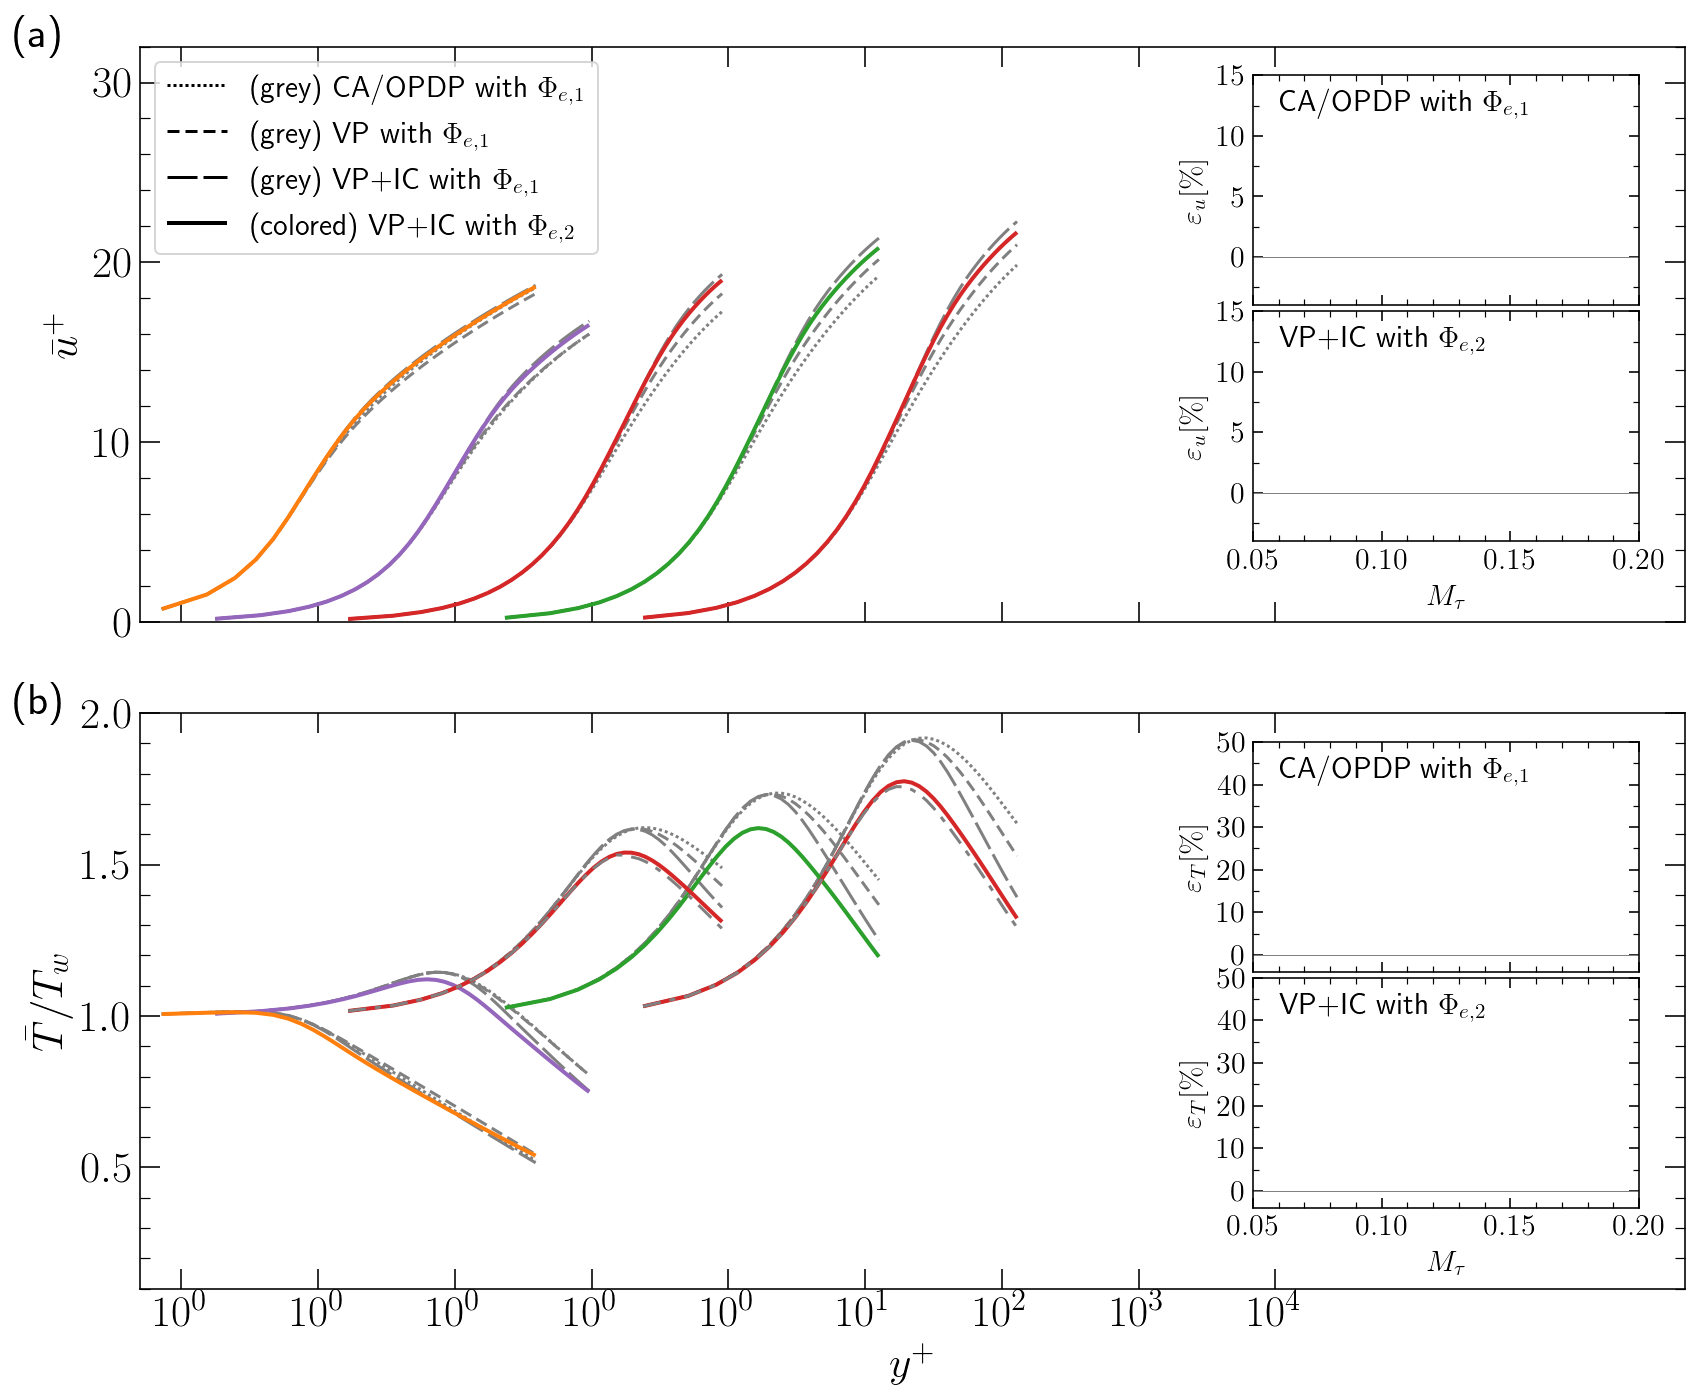

In [13]:
from matplotlib import rc, rcParams
import matplotlib.ticker as tck
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.minor.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})

fig, ax= plt.subplots(2,1,figsize=(12,10),sharex=True)               

#Insets to plot errors
axu  = inset_axes(ax[0],width="30%", height=1., loc=2)
axu2 = inset_axes(ax[0],width="30%", height=1., loc=2)
axT  = inset_axes(ax[1],width="30%", height=1., loc=2)
axT2 = inset_axes(ax[1],width="30%", height=1., loc=2)
ipu  = InsetPosition(ax[0], [0.72,0.55,0.25,0.4])
ipu2 = InsetPosition(ax[0], [0.72,0.14,0.25,0.4])
ipT  = InsetPosition(ax[1], [0.72,0.55,0.25,0.4])
ipT2 = InsetPosition(ax[1], [0.72,0.14,0.25,0.4])
axu.set_axes_locator( ipu)
axu2.set_axes_locator(ipu2)
axT.set_axes_locator( ipT)
axT2.set_axes_locator(ipT2)

Nc=28 #No. of cases
for e in [0,1,2]: #e=0 corresponds to Phie1, e=1 corresponds to Phie2 and e==2 corresponds to Phie2 and prt from DNS
    for k in [0,1,2]: #k=0 is CA/OPDP; k=1 is Present VP; k=2 is present VP+IC
        for group_name, group in groups:
            for row_index, row in group.reset_index().iterrows():
                loc=-1
                
                MTau      = row['Mtau']
                ReTau     = row['Retau']
                Bq        = row['Bq']
                viscLaw   = row['Visc law']
                Tw_dim    = row['T_w']
                iden      = int(row['Identifier'])

                if (e==0 or (e==1 and k==2) or (e==2 and (iden==2 or iden==4) and k==2)):

                    #The following lines are commented out since DNS data are not open to share, as also noted above
                    #     yplDNS = yplplot[:,iden]
                    #     uplDNS = uplplot[:,iden]
                    #     TDNS   = Tplot[:,iden]

                    #Load RANS results from saved files
                    ypl    = yplarrP[:,iden,k,e]    
                    upl    = uplarrP[:,iden,k,e]    
                    T      = TarrP[:,iden,k,e]    

                    if (e==1 and k==2):
                        color=row['Color']
                        lw=2.
                    else:
                        color='gray'
                        lw=1.5
                    
                    if   (e==0 and k==0):
                        dashes = (1,1)
                        label = r"(grey) CA/OPDP with $\Phi_{e,1}$" 
                    elif (e==0 and k==1):
                        dashes = (4,2)
                        label = r"(grey) VP with $\Phi_{e,1}$" 
                    elif (e==0 and k==2):
                        dashes = (10,2)
                        label = r"(grey) VP+IC with  $\Phi_{e,1}$" 
                    elif (e==1 and k==2):
                        dashes = (6,0)
                        label = r"(colored) VP+IC with $\Phi_{e,2}$" 
                    elif (e==2 and k==2):
                        dashes=(6,3,2,3)
                        
                    if (iden==17): loc=0
                    if (iden==25): loc=1
                    if (iden==2):  loc=2
                    if (iden==26): loc=3
                    if (iden==4):  loc=4 
                        
                    if (loc>=0):
                        # maskDNS = (yplDNS>0) & (yplDNS<ReTau)
                        mask    = (ypl>0) & (ypl<ReTau)

                        # if e==0 and k==0: #PLOT DNS ONLY ONCE
                        #     ax[0].semilogx(yplDNS[maskDNS]*10**loc,uplDNS[maskDNS]
                        #                               ,lw=1.5, color = 'k', fillstyle='none', linestyle='-')
                        #     ax[1].semilogx(yplDNS[maskDNS]*10**loc, TDNS[maskDNS]
                        #                               ,lw=1.5, color = 'k', fillstyle='none', linestyle='-')
                            
                        if e==0 or e==1: #PLOT VELOCITY FOR ALL THE COMBINATIONS EXCEPT WITH PRT FROM DNS
                            ax[0].semilogx(ypl[mask]*10**loc, upl[mask],lw=lw, color = color
                                       , fillstyle='none', dashes=dashes) 
                            
                        if e==0 or e==1 or e==2: #PLOT TEMP FOR ALL THE COMBINATIONS
                            ax[1].semilogx(ypl[mask]*10**loc, T[mask],lw=lw, color = color
                                           , fillstyle='none', dashes=dashes) 
                            
                        if loc==0:  # DUMMY PLOT FOR LEGENDS
                            ax[0].semilogx([],[],lw=lw, color = 'k'
                                           , fillstyle='none', dashes=dashes,label=label)                            
                            # if e==1: ax[0].semilogx([],[],lw=2., color = 'k'
                            #                , fillstyle='none', linestyle='-',label="(black) DNS")                         

                    erru = erruarrP[iden,k,e]
                    errT = errTarrP[iden,k,e]
                    if loc<0:
                        fillstyle = "none"
                    else:
                        fillstyle = "full"
                    
                    mew=1

                    # if (e==0 and k==0):
                    #     axu.plot(MTau, erru, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')    
                    #     axT.plot(MTau, errT, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')
                    # elif (e==1 and k==2):
                    #     axu2.plot(MTau, erru, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')    
                    #     axT2.plot(MTau, errT, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')
                
fs=22       

ax[0].set_ylim([0, 32])
ax[0].set_xlim([0.5, 10**11])
ax[1].set_ylim([0.1, 2])

ax[0].set_ylabel(r"$\bar u^+$",fontsize = fs)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = fs)
ax[1].set_xlabel(r"$y^+$",fontsize = fs)

ax[0].tick_params(axis='both', which='both', direction='in',labelsize=fs,right=True, top=True,bottom=True)
ax[1].tick_params(axis='both', which='both', direction='in',labelsize=fs,right=True, top=True,bottom=True)

ax[0].get_yaxis().set_major_formatter(tck.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(tck.ScalarFormatter())

ax[0].yaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(2))

ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1))

ax[0].set_xticks([1, 10, 100, 1000,10000,100000,1000000,10000000,100000000])
ax[1].set_xticks([1, 10, 100, 1000,10000,100000,1000000,10000000,100000000])

ax[0].set_xticklabels([])
ax[1].set_xticklabels([r"$10^0$",r"$10^0$",r"$10^0$",r"$10^0$",r"$10^0$",r"$10^1$",r"$10^2$",r"$10^3$",r"$10^4$"])

ax[0].tick_params(axis='both', which='major', size=10)
ax[0].tick_params(axis='both', which='minor', size=5)
ax[1].tick_params(axis='both', which='major', size=10)
ax[1].tick_params(axis='both', which='minor', size=5)

ax[0].text(0.06,0 + (32-0)*1, "(a)", fontsize = fs, rotation = 0)
ax[1].text(0.06,0.1+(2-0.1)*1, "(b)", fontsize = fs, rotation = 0)

ax[0].legend(loc="upper left",fontsize=15)

#Inset

fs=15
for a in [axu,axu2,axT,axT2]:
    if a==axu or a==axT:
        labelbot = False
    else:
        labelbot = True
        a.set_xlabel(r"$M_\tau$",fontsize = fs)
        
    a.tick_params(axis='both', which='both', direction='in',labelsize=15,right=True, top=True,bottom=True,
                  labelbottom=labelbot)
    a.tick_params(axis='both', which='major', size=5)
    a.tick_params(axis='both', which='minor', size=3)

    if a==axu or a==axu2:
        a.yaxis.set_major_locator(MultipleLocator(5))
        a.yaxis.set_minor_locator(MultipleLocator(2.5))
        a.set_ylim([-4, 15])
        a.set_ylabel(r"$\varepsilon_{u}[\%]$",fontsize = fs)
    else:
        a.yaxis.set_major_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(5))
        a.set_ylim([-4, 50])
        a.set_ylabel(r"$\varepsilon_{T}[\%]$",fontsize = fs)

    a.set_xlim([0.05, 0.2])
    a.axhline(y=0, color="gray", linestyle="-",lw=0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.05))
    a.xaxis.set_minor_locator(MultipleLocator(0.01))

axu.text(0.06,-4+(15--4)*0.85, r"CA/OPDP with $\Phi_{e,1}$", fontsize = fs, rotation = 0)
axu2.text(0.06,-4+(15--4)*0.85, r"VP+IC with $\Phi_{e,2}$", fontsize = fs, rotation = 0)
axT.text(0.06,-4+(50--4)*0.85, r"CA/OPDP with $\Phi_{e,1}$", fontsize = fs, rotation = 0)
axT2.text(0.06,-4+(50--4)*0.85, r"VP+IC with $\Phi_{e,2}$", fontsize = fs, rotation = 0)


plt.tight_layout()

# b) Low- and High-Mach Channels

In [14]:
DNS = pd.read_csv('DNS_chan.csv')
groups = DNS.groupby(by='Author', as_index=True)

In [ ]:
turbModels = [SST(),SST(),SST()]
errlimarr  = [1e-4,1e-4,1e-4]
Corrarr = ["CA/OPDP", "VP", "VP+IC"]

N=60
Nc=11
Nt = int(np.size(turbModels))
Ne = 2 

#Variable to store the results which will be later used for plotting
ystarrP_C    = np.zeros([N,Nc,Nt,Ne])
yplarrP_C    = np.zeros([N,Nc,Nt,Ne])
ustarrP_C    = np.zeros([N,Nc,Nt,Ne])
uplarrP_C    = np.zeros([N,Nc,Nt,Ne])
mut_muarrP_C = np.zeros([N,Nc,Nt,Ne])
TarrP_C      = np.zeros([N,Nc,Nt,Ne])
erruarrP_C   = np.zeros([  Nc,Nt,Ne])
errTarrP_C   = np.zeros([  Nc,Nt,Ne])

#Mesh for a Channel 
mesh = Mesh(int(2*N),2,6,1) #(No. of points, domain size, stretching factor, tanhyp=1 implies streching on both sides)

for e in np.arange(0,Ne): #e=0: Phi_e1; e=1: Phi_e2
    for k in np.arange(0,Nt):
        print("\n")
        for group_name, group in groups:
            for row_index, row in group.reset_index().iterrows():
                
                #Read input parameters for difference cases
                MTau      = row['Mtau']
                ReTau     = row['Retau']
                viscLaw   = row['Visc law']
                nvisc     = row['ViscExp']
                flow      = row['Flow type']
                extsou    = row['Extsource']
                iden      = int(row['Identifier']) # unique identifier attached to each case

                #Printing somethings for clarity
                if flow=="LowMachChan":  
                    Phi_type = "Phi_ext"; Prt_type = "1.0"
                else:
                    if e==0:
                        Phi_type = "Phi_e1"
                        Prt_type = "0.9"
                    elif e==1:
                        Phi_type = "Phi_e2"
                        Prt_type = "0.9"  
                print(Corrarr[k]+' with '+Phi_type+' and Prt = '+Prt_type+' for Mach '+str(row['Mb'])+ ' case of ' + row['Author'])

                #The following lines of code are associated with estimating epsilon from DNS for cases
                # where it is not readily available. Here we use our own M3Retau1160 case which is similar
                # to the high-Mach case of Trettel-Larsson 2016.
                abudTL = np.fromfile('PresentAuthorsdata/abud.bin', dtype=float).reshape(6,480,7,order='F')    
                dnsTL  = np.loadtxt( 'PresentAuthorsdata/post.txt', skiprows=1)    
                epsdns = -0.5*(abudTL[0,:,4]+abudTL[3,:,4]+abudTL[5,:,4])/(dnsTL[:,4]*dnsTL[:,2]**3*dnsTL[:,1]) #Semi local eps
                ystdns = dnsTL[:,0]*dnsTL[:,1]

                if flow=="HighMachChan":
                    Prt_interp = np.ones_like(mesh.y)*0.9
                elif flow=="LowMachChan":
                    Prt_interp = np.ones_like(mesh.y)*1

                #Solver    
                ypl,yst,T,turbVars,mut,mu,r,upl,niter,ust,Mt\
                                                  = solver(
                                                    ReTau    = ReTau, 
                                                    MTau     = MTau, 
                                                    Bq       = 0, #Bq is irrelevant for channels
                                                    viscLaw  = viscLaw, 
                                                    nvisc    = nvisc,  #not relevant for BLs
                                                    Tw_dim   = 300, # not relevant since the cases use PowerLaw for viscosity
                                                    gamma    = 1.4,
                                                    Pr       = 0.72,
                                                    kappa    = 0.41,
                                                    mesh     = mesh,
                                                    turbModel= turbModels[k],
                                                    CompCorr = Corrarr[k],
                                                    errlim   = errlimarr[k],
                                                    Prt      = Prt_interp,
                                                    epsdns   = epsdns,
                                                    ystdns   = ystdns,
                                                    e        = e, 
                                                    extsou   = extsou, #not relevant for BLs
                                                    flow     = flow,
                                                    verbose  = False)

            
                #The following lines compute errors with respect to DNS. 
                #They are commented out because DNS data are not openly available for sharing
                #Please contact the cited authors for the data.
                
                # nlenDNS = len(yplDNSarr[:,0])//2
                # yplDNS        = yplDNSarr[:nlenDNS,iden]
                # uplDNS        = uplDNSarr[:nlenDNS,iden]
                # TDNS          = TDNSarr[:nlenDNS,iden]
                # mask= ((ypl>=yplDNS[0]) & (ypl<=[yplDNS[-1]]) & (mesh.y<=1)) #Limit between y/H=0 to y/H=1
                # interp_func   = interp1d(yplDNS[:], uplDNS[:])
                # uplDNS_interp = interp_func(ypl[mask])
                
                # interp_func = interp1d(yplDNS[:], TDNS[:])
                # TDNS_interp = interp_func(ypl[mask])

                # erru            = np.abs(upl[mask][-1] - uplDNS_interp[-1])/(uplDNS_interp[-1])*100
                # errT            = np.abs(T[mask][-1] - TDNS_interp[-1])/(TDNS_interp[-1])*100


                ystarrP_C[:,iden,k,e]    = yst[0:int(len(yst)//2)]
                yplarrP_C[:,iden,k,e]    = ypl[0:int(len(yst)//2)]
                ustarrP_C[:,iden,k,e]    = ust[0:int(len(yst)//2)]
                uplarrP_C[:,iden,k,e]    = upl[0:int(len(yst)//2)]
                mut_muarrP_C[:,iden,k,e] = (mut/mu)[0:int(len(yst)//2)]
                TarrP_C[:,iden,k,e]      = T[0:int(len(yst)//2)]
                # erruarrP_C[iden,k,e]     = erru
                # errTarrP_C[iden,k,e]     = errT
            



CA/OPDP with Phi_ext and Prt = 1.0 for Mach 0.0 case of Patel et al. (2016)
CA/OPDP with Phi_ext and Prt = 1.0 for Mach 0.0 case of Pecnik & Patel (2017)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 0.7 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 0.7 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 1.7 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 1.7 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 1.7 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 3.0 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 3.0 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 3.0 case of Trettel & Larsson (2016)
CA/OPDP with Phi_e1 and Prt = 0.9 for Mach 4.0 case of Trettel & Larsson (2016)


VP with Phi_ext and Prt = 1.0 for Mach 0.0 case of Patel et al. (2016)
VP with Phi_ext and Prt = 1.0 for Mach 0.0 case of 

In [69]:
#Save computed data to avoid recomputation again
np.save('DataForPlotting/ystRANSP_C.npy', ystarrP_C)
np.save('DataForPlotting/yplRANSP_C.npy', yplarrP_C)
np.save('DataForPlotting/ustRANSP_C.npy', ustarrP_C)
np.save('DataForPlotting/uplRANSP_C.npy', uplarrP_C)
np.save('DataForPlotting/TRANSP_C.npy'  , TarrP_C)
np.save('DataForPlotting/erruRANSP_C.npy'  , erruarrP_C)
np.save('DataForPlotting/errTRANSP_C.npy'  , errTarrP_C)

# Plotting Channels

In [70]:
#Load saved data
ystarrP_C=np.load('DataForPlotting/ystRANSP_C.npy')
yplarrP_C=np.load('DataForPlotting/yplRANSP_C.npy' )
ustarrP_C=np.load('DataForPlotting/ustRANSP_C.npy' )
uplarrP_C=np.load('DataForPlotting/uplRANSP_C.npy' )
TarrP_C  =np.load('DataForPlotting/TRANSP_C.npy' )
erruarrP_C  =np.load('DataForPlotting/erruRANSP_C.npy' )
errTarrP_C  =np.load('DataForPlotting/errTRANSP_C.npy' )

/tmp/ipykernel_6190/2752887692.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


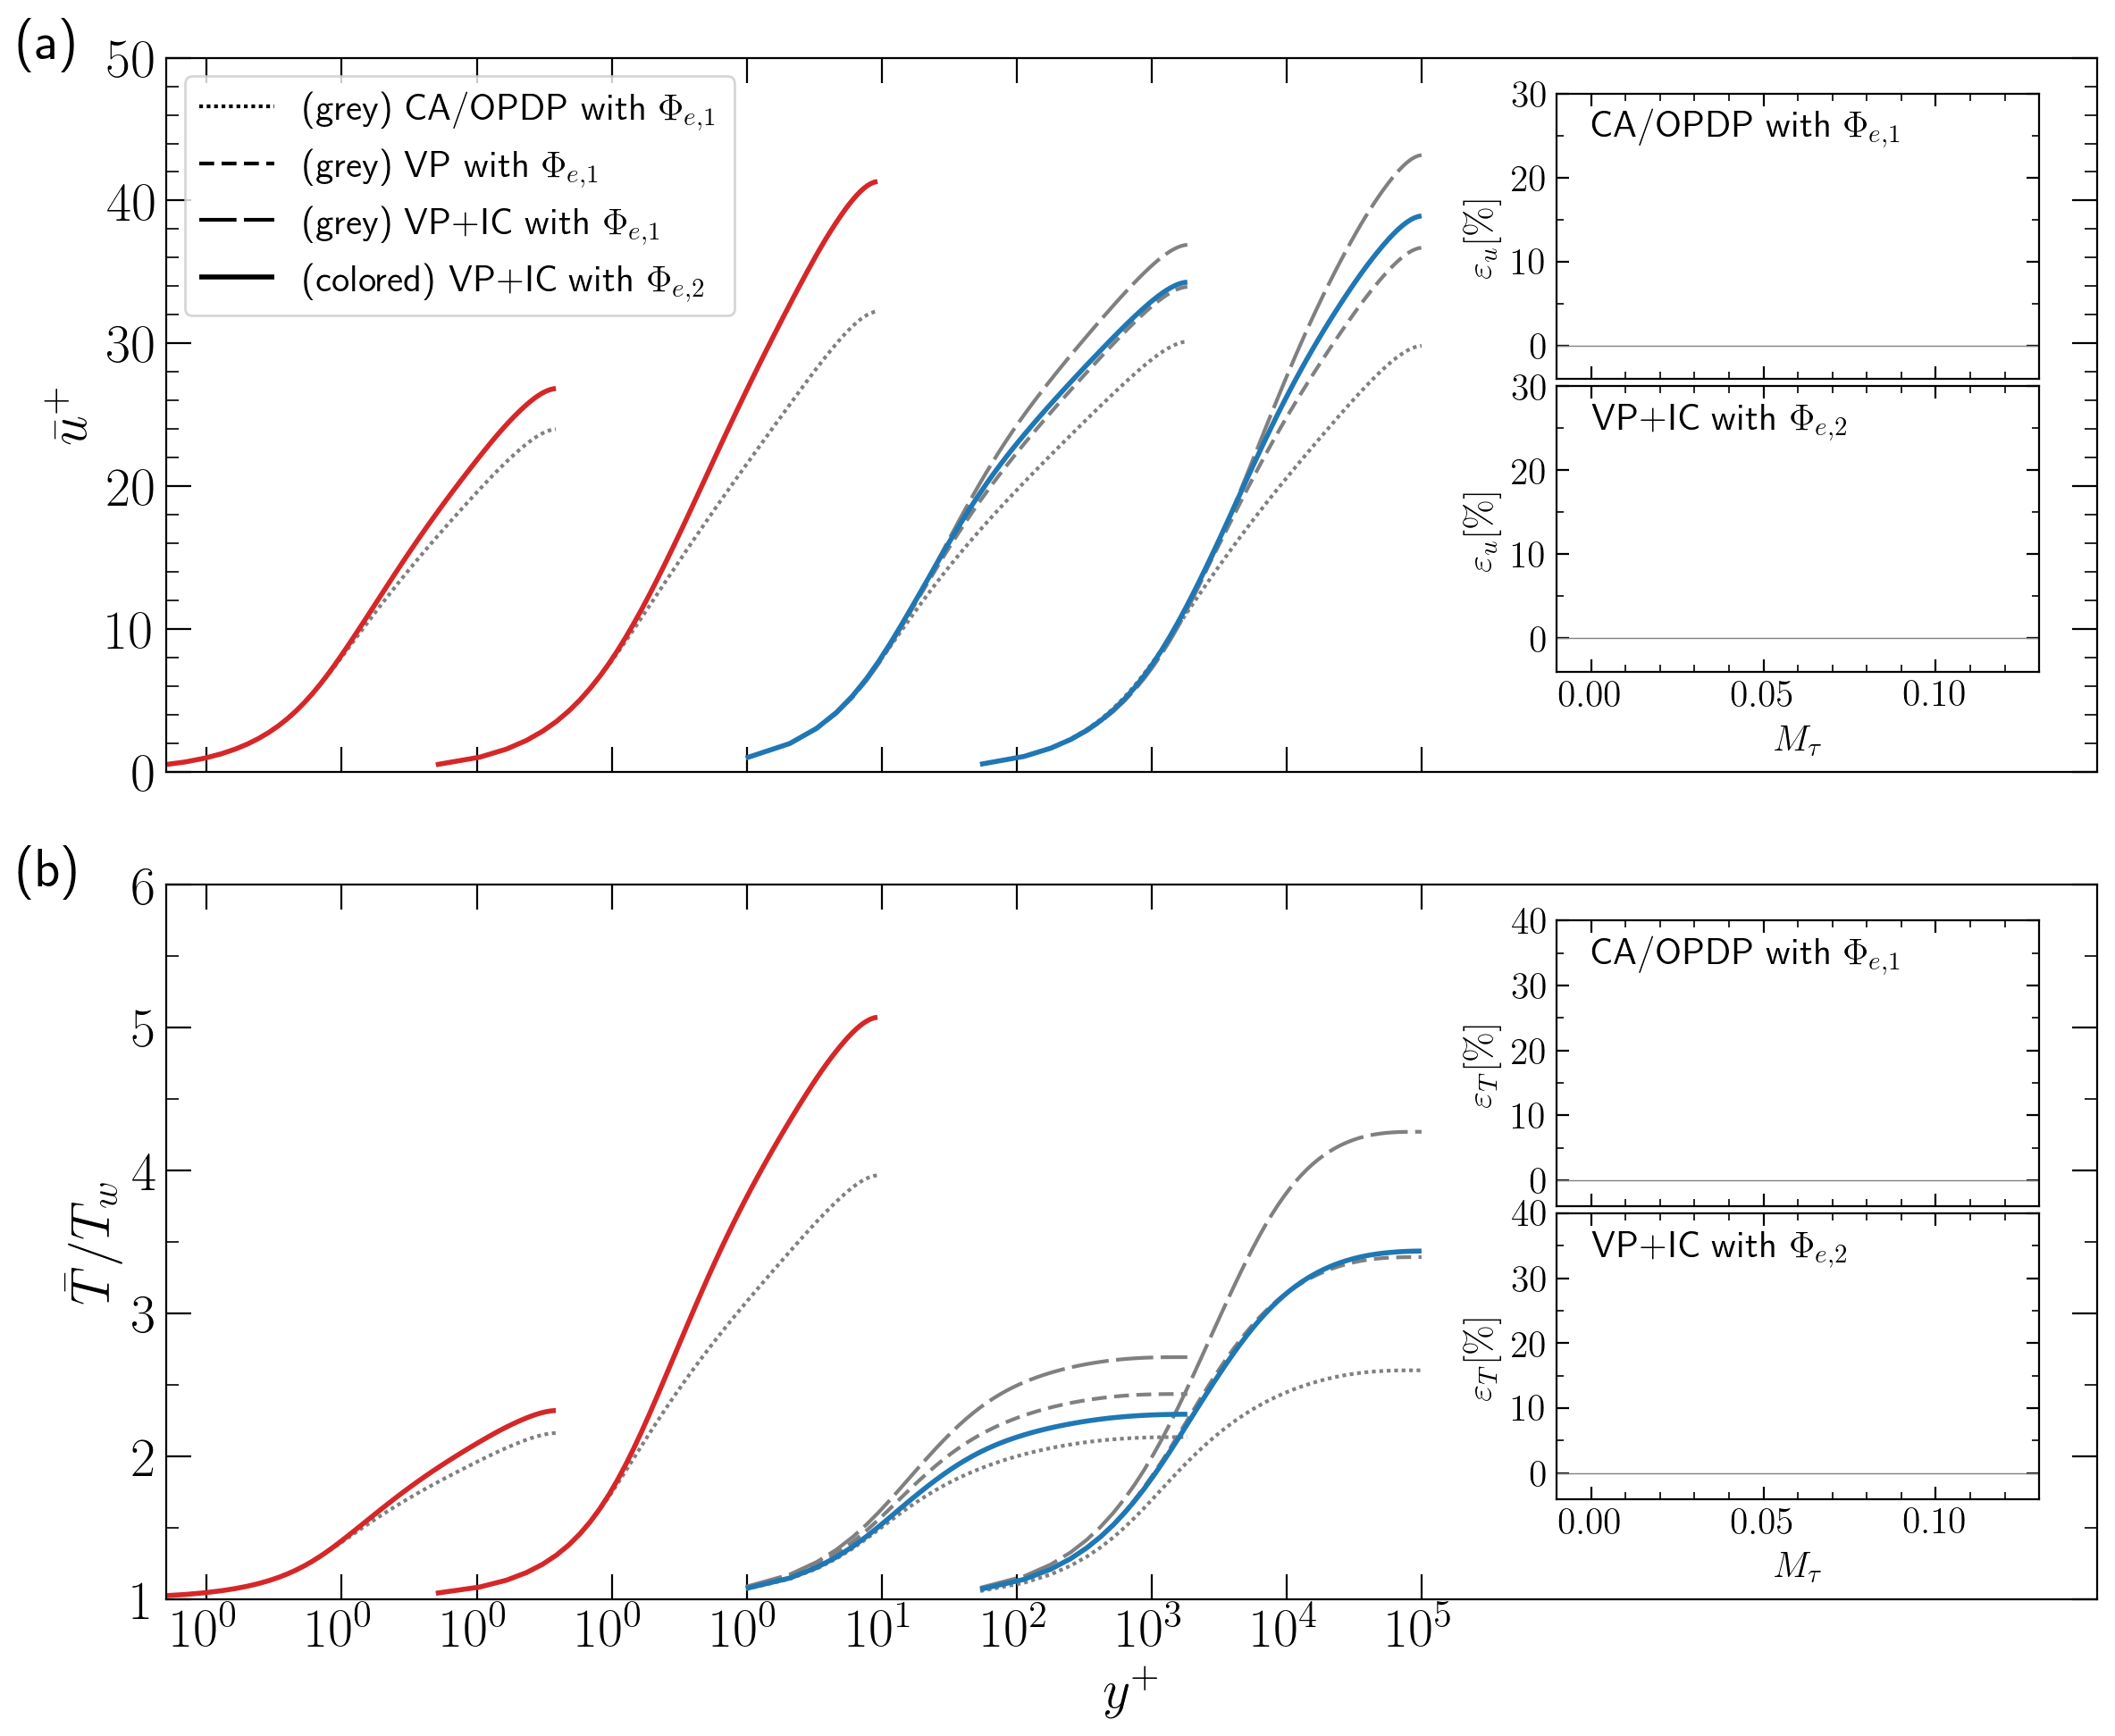

In [71]:
from matplotlib import rc, rcParams
import matplotlib.ticker as tck
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.minor.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})



fig, ax= plt.subplots(2,1,figsize=(12,10),sharex=True)               

# Inset
axu  = inset_axes(ax[0],width="30%", height=1., loc=2)
axu2 = inset_axes(ax[0],width="30%", height=1., loc=2)
axT  = inset_axes(ax[1],width="30%", height=1., loc=2)
axT2 = inset_axes(ax[1],width="30%", height=1., loc=2)
ipu  = InsetPosition(ax[0], [0.72,0.55,0.25,0.4])
ipu2 = InsetPosition(ax[0], [0.72,0.14,0.25,0.4])
ipT  = InsetPosition(ax[1], [0.72,0.55,0.25,0.4])
ipT2 = InsetPosition(ax[1], [0.72,0.14,0.25,0.4])
axu.set_axes_locator( ipu)
axu2.set_axes_locator(ipu2)
axT.set_axes_locator( ipT)
axT2.set_axes_locator(ipT2)

Nc=11
for e in np.arange(0,2):
    for k in np.arange(0,3):
        for group_name, group in groups:
            for row_index, row in group.reset_index().iterrows():
                loc=-1
                MTau      = row['Mtau']
                ReTau     = row['Retau']
                iden      = int(row['Identifier'])

                if (e==0 or (e==1 and k==2)):
                    # nlenDNS = len(yplDNSarr[:,0])//2
                    # yplDNS        = yplDNSarr[:nlenDNS,iden]
                    # uplDNS        = uplDNSarr[:nlenDNS,iden]
                    # TDNS          = TDNSarr[:nlenDNS,iden] 

                    ypl    = yplarrP_C[:,iden,k,e]    
                    yst    = ystarrP_C[:,iden,k,e]    
                    upl    = uplarrP_C[:,iden,k,e]    
                    ust    = ustarrP_C[:,iden,k,e]    
                    T      = TarrP_C[:,iden,k,e]    

                    if (e==1 and k==2):
                        color=row['Color']
                        lw=2.
                    else:
                        color='gray'
                        lw=1.5
                    
                    if   (e==0 and k==0):
                        dashes = (1,1)
                        label = r"(grey) CA/OPDP with $\Phi_{e,1}$" 
                    elif (e==0 and k==1):
                        dashes = (4,2)
                        label = r"(grey) VP with $\Phi_{e,1}$" 
                    elif (e==0 and k==2):
                        dashes = (10,2)
                        label = r"(grey) VP+IC with $\Phi_{e,1}$" 
                    elif (e==1 and k==2):
                        dashes = (6,0)
                        label = r"(colored) VP+IC with $\Phi_{e,2}$" 
                    elif (e==2 and k==2):
                        dashes=(6,3,2,3)


                    if (iden==10): loc=0
                    if (iden==9):  loc=2
                    if (iden==7):  loc=4 
                    if (iden==8):  loc=6 

                    if (loc>=0):
                        # maskDNS = (yplDNS>0) & (yplDNS<ReTau)
                        mask    = (ypl>0) & (ypl<ReTau)
                        # if e==0 and k==0: #PLOT DNS ONLY ONCE
                        #     ax[0].semilogx(yplDNS[maskDNS]*10**loc,uplDNS[maskDNS]
                        #                               ,lw=1.5, color = 'k', fillstyle='none', linestyle='-')
                        #     ax[1].semilogx(yplDNS[maskDNS]*10**loc, TDNS[maskDNS]
                        #                               ,lw=1.5, color = 'k', fillstyle='none', linestyle='-')
                            
                        if e==0 or e==1: #PLOT VELOCITY FOR ALL THE COMBINATIONS EXCEPT WITH PRT FROM DNS
                            ax[0].semilogx(ypl[mask]*10**loc, upl[mask],lw=lw, color = color
                                       , fillstyle='none', dashes=dashes) 
                            
                        if e==0 or e==1 or e==2: #PLOT TEMP FOR ALL THE COMBINATIONS
                            ax[1].semilogx(ypl[mask]*10**loc, T[mask],lw=lw, color = color
                                           , fillstyle='none', dashes=dashes) 
                            
                        if loc==0:  # DUMMY PLOT FOR LEGENDS
                            ax[0].semilogx([],[],lw=lw, color = 'k'
                                           , fillstyle='none', dashes=dashes,label=label)                            
                            # if e==1: ax[0].semilogx([],[],lw=2., color = 'k'
                            #                , fillstyle='none', linestyle='-',label="(black) DNS")                      


                    erru = erruarrP_C[iden,k,e]
                    errT = errTarrP_C[iden,k,e]

                    if e==1:
                        if loc<0:
                            fillstyle = "none"
                        else:
                            fillstyle = "full"

                        mew=1

                    if loc<0:
                        fillstyle = "none"
                    else:
                        fillstyle = "full"
                    
                    mew=1
    
                    # if (e==0 and k==0):
                    #     axu.plot(MTau, erru, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')    
                    #     axT.plot(MTau, errT, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')
                    # elif (e==1 and k==2):
                    #     axu2.plot(MTau, erru, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')    
                    #     axT2.plot(MTau, errT, marker = row['Symbol'], color = row['Color'],
                    #         ms=8*row['Size'], mew=mew, fillstyle=fillstyle, linestyle='None')
                        
fs=22            
ax[0].set_ylim([0, 50])
ax[0].set_xlim([0.5, 10**14])
ax[1].set_ylim([1, 6])

ax[0].set_ylabel(r"$\bar u^+$",fontsize = fs)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = fs)
ax[1].set_xlabel(r"$y^+$",fontsize = fs)

ax[0].tick_params(axis='both', which='both', direction='in',labelsize=fs,right=True, top=True,bottom=True)
ax[1].tick_params(axis='both', which='both', direction='in',labelsize=fs,right=True, top=True,bottom=True)

ax[0].get_yaxis().set_major_formatter(tck.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(tck.ScalarFormatter())

ax[0].yaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(2))

ax[1].yaxis.set_major_locator(MultipleLocator(1))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))

ax[0].set_xticks([1, 10, 100, 1000,10000,100000,1000000,10000000,100000000,1000000000])
ax[1].set_xticks([1, 10, 100, 1000,10000,100000,1000000,10000000,100000000,1000000000])

ax[0].set_xticklabels([])
ax[1].set_xticklabels([r"$10^0$",r"$10^0$",r"$10^0$",r"$10^0$",r"$10^0$",r"$10^1$",r"$10^2$",r"$10^3$",
                       r"$10^4$",r"$10^5$"])

ax[0].tick_params(axis='both', which='major', size=10)
ax[0].tick_params(axis='both', which='minor', size=5)
ax[1].tick_params(axis='both', which='major', size=10)
ax[1].tick_params(axis='both', which='minor', size=5)

ax[0].text(0.04, 50*1, "(a)", fontsize = fs, rotation = 0)
ax[1].text(0.04,1+(6-1)*1, "(b)", fontsize = fs, rotation = 0)

ax[0].legend(loc="upper left",fontsize=15)

#Inset

fs=15
for a in [axu,axu2,axT,axT2]:
    if a==axu or a==axT:
        labelbot = False
    else:
        labelbot = True
        a.set_xlabel(r"$M_\tau$",fontsize = fs)
        
    a.tick_params(axis='both', which='both', direction='in',labelsize=15,right=True, top=True,bottom=True,
                  labelbottom=labelbot)
    a.tick_params(axis='both', which='major', size=5)
    a.tick_params(axis='both', which='minor', size=3)

    if a==axu or a==axu2:
        a.yaxis.set_major_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(5))
        a.set_ylim([-4, 30])
        a.set_ylabel(r"$\varepsilon_{u}[\%]$",fontsize = fs)
    else:
        a.yaxis.set_major_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(5))
        a.set_ylim([-4, 40])
        a.set_ylabel(r"$\varepsilon_{T}[\%]$",fontsize = fs)

    a.set_xlim([-0.01, 0.13])
    a.axhline(y=0, color="gray", linestyle="-",lw=0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.05))
    a.xaxis.set_minor_locator(MultipleLocator(0.01))

axu.text(0.00,-4+(30--4)*0.85, r"CA/OPDP with $\Phi_{e,1}$", fontsize = fs, rotation = 0)
axu2.text(0.0,  -4+(30--4)*0.85, r"VP+IC with $\Phi_{e,2}$", fontsize = fs, rotation = 0)
axT.text(0.0,   -4+(40--4)*0.85, r"CA/OPDP with $\Phi_{e,1}$", fontsize = fs, rotation = 0)
axT2.text(0.0,  -4+(40--4)*0.85, r"VP+IC with $\Phi_{e,2}$", fontsize = fs, rotation = 0)

plt.tight_layout()